## Постановка задачи
#### Задача достижимости с регулярными ограничениями
Для данного графа и регулярного выражения требуется найти все пары вершин в графе так, чтобы путь между ними удовлетворял данному регулярному выражению<br><br>
$RPQ = \{(v_i, v_j)\ |\ \exists \pi: \ v_i \pi v_j \ \in \ L;\  v_i,\  v_j \in V\}$<br>
Где $v_i, v_j$ - пара вершин, для которой существует путь<br>
    $L$ - язык, заданный регулярным выражением

#### Конкретные задачи достижимости
- Достижимость между всеми парами вершин
- Достижимость для всего множества заданных вершин
- Достижимость для каждой из заданного множества стартовых вершин.

#### Цель работы 
Целью работы является анализ производительности решений задач достижимости между всеми парами вершин и с заданным множеством стартовых вершин с регулярными ограничениями.<br>
Для достижения данной цели были поставлены следующие вопросы
- Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?
- Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?
- На сколько решение третьей задачи медленнее решения второй при одинаковых начальных условиях?


## Описание исследуемых решений
В работе используются алгоритмы, которые были написаны в рамках предыдущих задач.
#### Тензорный алгоритм
Алгоритм выполнения регулярных запросов к графу, основанный на построении пересечения двух автоматов: автомата построенного на основе входного графа и автомата построенного на основе регулярного выражения, и последующим использованием транзитивного замыкания.
Алгоритм реализован в функции `regular_path_query` 
#### Обход графа в ширину (BFS)
Алгоритм основан на обходе графа в ширину
Реализован в функции `get_reachable_final_nodes_constrained`

## Графы, используемые для эксперимента
Для эксперимента были выбраны следующие графы:
1. skos (144 вершины, 252 ребра, 21 уникальная метка)
2. biomedical (341 вершина, 459 ребер, 10 уникальных меток)
3. wine (733 вершина, 1839 ребер, 35 уникальных меток)<br>


Выбранные графы существенно отличаются в количестве ребер и вершин, что позволяет проводить исследования для разных реализаций алгоритма, а так же все эти графы имеют большое количество уникальныз меток, которые позволят построить разные регулярные ограничения.

## Результаты экспериментов

## Анализ результатов экспериментов
- Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?
- Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?
- На сколько решение третьей задачи медленнее решения второй при одинаковых начальных условиях?


# Подключение необходимых зависимостей

In [182]:
from project.automaton_lib import regular_path_query, get_reachable_final_nodes_constrained
from project.graph_lib import get_graph_data, download_graph
from pyformlang.regular_expression import Regex
from scipy.sparse import (
    lil_matrix,
    csr_matrix,
    dok_matrix,
    csc_matrix
)

import matplotlib.pyplot as plt
import cfpq_data

# Диаграммы

In [183]:
matrix_names = ["lil_matrix", "dok_matrix", "csr_matrix", "csc_matrix"]
graph_names = ["skos", "biomedical", "wine"]
regex_names = [
    "(l1 | l2)* l3",
    "(l3 | l4)+ l1*",
    "l1 l2 l3 (l4|l1)*",
    "l1+ (l4|l3)* (l4|l1) l3 l2*",
]


def draw_diagram_for_regex(measures, offset):
    stride = [offset + i * 0.2 for i in range(4)]
    colors = ['red', 'green', 'blue', 'yellow']
    keys, values = zip(*measures.items())
    values_avg = list(map(lambda e: e.average, values))
    values_stdev = list(map(lambda e: e.stdev, values))
    plt.bar(
        stride, 
        values_avg,
        0.18,
        yerr=values_stdev, 
        color=colors, 
        label=keys
    )


def draw_diagram_for_matrices(measures):
    for i, m in enumerate(measures.keys()):
        draw_diagram_for_regex(measures[m], i)


def draw_diagram(title, measures):
    stride = [0.3 + i for i in range(4)]
    for g, graph_name in zip(measures.keys(), graph_names):
        plt.figure().set_figwidth(10)
        plt.title(f"{title} ({graph_name})")
        draw_diagram_for_matrices(measures[g])    
        plt.xticks(stride, regex_names)
        plt.legend(labels=matrix_names, loc=1)
        plt.show()
        

# Построение регулярного выражения для графа
Для каждого графа будет построено 4 запроса вида
1. `(l1 | l2)* l3`
2. `(l3 | l4)+ l1*`
3. `l1 l2 l3 (l4|l1)*`
4. `l1+ (l4|l3)* (l4|l1) l3 l2*`


In [184]:
def regex_of_graph(graph):
    graph_data = get_graph_data(graph)
    labels = list(graph_data.labels)
    assert len(labels) > 3, "Слишком мало меток, минимум 4"
    l1 = labels[0]
    l2 = labels[1]
    l3 = labels[2]
    l4 = labels[4]
    return [
        f"({l1}|{l2})* {l3}",
        f"({l3}|{l4})+ {l1}*",
        f"{l1} {l2} {l3} ({l4}|{l1})*",
        f"{l1}+ ({l4}|{l3})* ({l4}|{l1}) {l3} {l2}*",
    ]

## Функция для измерения времени

In [185]:
matrix_constructors = [lil_matrix, dok_matrix, csr_matrix, csc_matrix]
graph_names = ["skos", "biomedical", "wine"]
graphs = [download_graph(g) for g in graph_names]
regex_names = [
    "(l1 | l2)* l3",
    "(l3 | l4)+ l1*",
    "l1 l2 l3 (l4|l1)*",
    "l1+ (l4|l3)* (l4|l1) l3 l2*",
]

def time_rpq(algorithm, graph, regex, starting):
    measure = %timeit -r 1 -n 1 -o algorithm(graph, regex, starting)
    return measure


def time_rpq_for_all_matrices(algorithm, graph, regex, starting):
    measures = dict()

    for m in matrix_constructors:
        defined_algorithm = algorithm(m)
        measures[m.__name__] = time_rpq(defined_algorithm, graph, regex, starting)

    return measures


def time_rpq_for_graph(algorithm, graph, gen_starting):
    regexes = regex_of_graph(graph)
    measures = dict()

    if gen_starting is not None:
        starting = cfpq_data.generate_multiple_source_percent(graph, 50, seed=0)
    else:
        starting = None

    for regex_name, regex in zip(regex_names, regexes):
        actual_regex = Regex(regex)
        measures[regex_name] = time_rpq_for_all_matrices(algorithm, graph, actual_regex, starting)

    return measures


def time_rpq_for_algorithm(algorithm, gen_starting):
    measures = dict()

    for g in graphs:
        measures[g] = time_rpq_for_graph(algorithm, g, gen_starting)

    return measures

[2023-10-19 01:12:53]>INFO>Found graph with name='skos'
[2023-10-19 01:12:53]>INFO>Load archive graph_archive=PosixPath('/home/arthur/.local/lib/python3.10/site-packages/cfpq_data/data/graphs/skos.tar.gz')
[2023-10-19 01:12:53]>INFO>Unzip graph name='skos' to file graph=PosixPath('/home/arthur/.local/lib/python3.10/site-packages/cfpq_data/data/graphs/skos/skos.csv')
[2023-10-19 01:12:53]>INFO>Remove archive graph_archive=PosixPath('/home/arthur/.local/lib/python3.10/site-packages/cfpq_data/data/graphs/skos.tar.gz')
[2023-10-19 01:12:53]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f8eeb3b6920> from path=PosixPath('/home/arthur/.local/lib/python3.10/site-packages/cfpq_data/data/graphs/skos/skos.csv')
[2023-10-19 01:12:53]>INFO>Found graph with name='biomedical'
[2023-10-19 01:12:54]>INFO>Load archive graph_archive=PosixPath('/home/arthur/.local/lib/python3.10/site-packages/cfpq_data/data/graphs/biomedical.tar.gz')
[2023-10-19 01:12:54]>INFO>Unzip graph name='

# Алгоритм тензорного произведения (все вершины стартовые)

[2023-10-19 01:12:54]>INFO>Generate set of source vertices of 72 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f8eeb3b6920> for multiple-source evaluation
/home/arthur/.local/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/arthur/.local/lib/python3.10/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


96.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
80.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
120 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/home/arthur/.local/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


121 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
78.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
84.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
119 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
117 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
105 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
76.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
122 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
155 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
109 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
98.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
189 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


[2023-10-19 01:12:56]>INFO>Generate set of source vertices of 170 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f8eeb3b67d0> for multiple-source evaluation


145 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
91.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
85.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
170 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
172 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
99.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
89 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
183 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
172 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
95.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
94 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
171 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
186 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
99.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
101 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


[2023-10-19 01:12:58]>INFO>Generate set of source vertices of 366 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x7f8eeaf1df90> for multiple-source evaluation


184 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
175 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.06 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
981 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.47 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.34 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
900 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
951 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.38 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.59 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.03 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.38 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.39 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
998 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1.1 s ± 0 ns per loop (mean ± std. dev. o

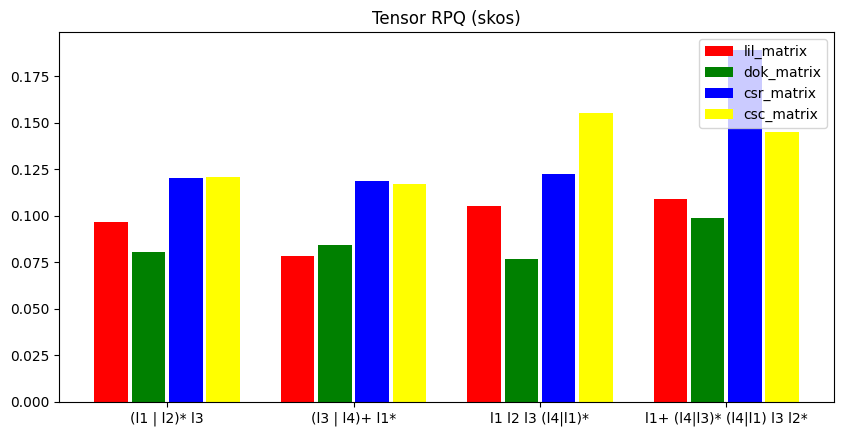

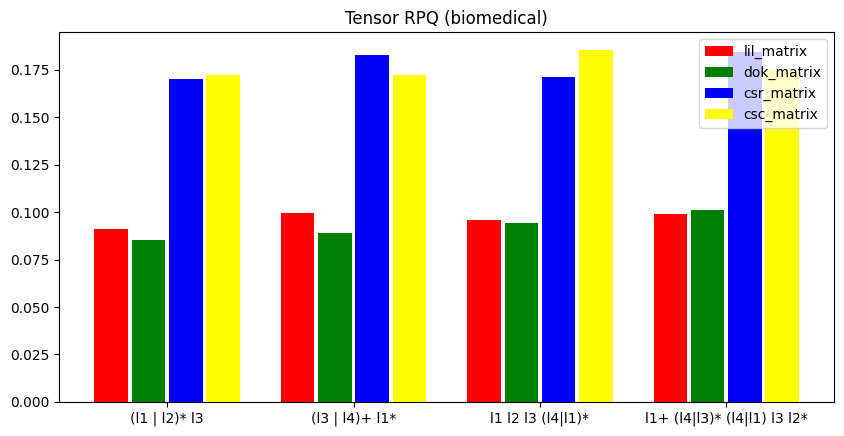

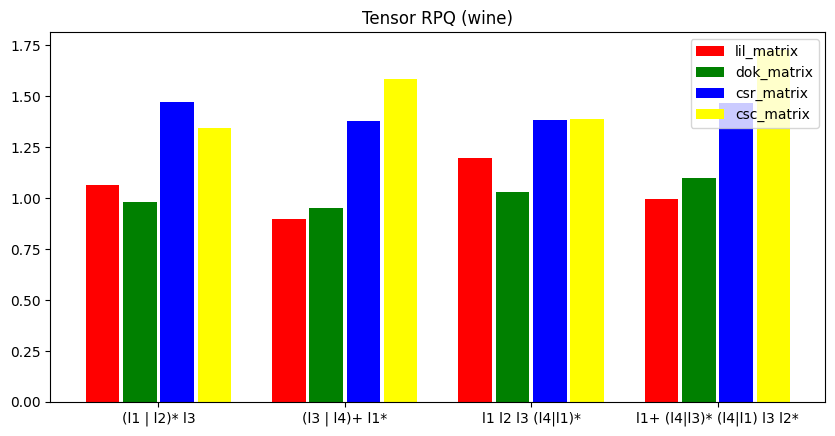

In [186]:
tensor_algorithm = lambda matrix: lambda graph, regex, starting: regular_path_query(graph, starting, None, regex, use_matrix=matrix)
measures = time_rpq_for_algorithm(tensor_algorithm, False)
draw_diagram("Tensor RPQ (All starting)", measures)

# Алгоритм тензорного произведения (половина вершин - стартовые)

In [ ]:
tensor_algorithm = lambda matrix: lambda graph, regex, starting: regular_path_query(graph, starting, None, regex, use_matrix=matrix)
measures = time_rpq_for_algorithm(tensor_algorithm, True)
draw_diagram("Tensor RPQ (All starting)", measures)

# BFS (все вершины - стартовые)

In [187]:
bfs_algorithm = lambda matrix: lambda graph, regex, starting: get_reachable_final_nodes_constrained(graph, regex, starting, None, False, use_matrix=matrix)
measures = time_rpq_for_algorithm(tensor_algorithm, False)
draw_diagram("BFS (All starting)", measures)

# BFS (половина вершин - стартовые)

In [ ]:
bfs_algorithm = lambda matrix: lambda graph, regex, starting: get_reachable_final_nodes_constrained(graph, regex, starting, None, False, use_matrix=matrix)
measures = time_rpq_for_algorithm(tensor_algorithm, False)
draw_diagram("BFS (All starting)", measures)